# Home Credit Default Risk

## Introduction

### Load the data efficiently

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)
InteractiveShell.ast_node_interactivity = "all"
from helpers import *

In [2]:
# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

(60, 20)

In [3]:
def reduce_mem_usage(df):
    """iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [4]:
print("-" * 80)
print("train")
train = import_data("data/application_train.csv")

print("-" * 80)
print("test")
test = import_data("data/application_test.csv")

print("-" * 80)
print("bureau_balance")
bureau_balance = import_data("data/bureau_balance.csv")

print("-" * 80)
print("bureau")
bureau = import_data("data/bureau.csv")

print("-" * 80)
print("credit_card_balance")
credit_card = import_data("data/credit_card_balance.csv")

print("-" * 80)
print("installments_payments")
installments = import_data("data/installments_payments.csv")

print("-" * 80)
print("pos_cash_balance")
pos_cash = import_data("data/POS_CASH_balance.csv")

print("-" * 80)
print("previous_application")
previous_app = import_data("data/previous_application.csv")

--------------------------------------------------------------------------------
train


Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
--------------------------------------------------------------------------------
bureau_balance
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
--------------------------------------------------------------------------------
bureau
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
--------------------------------------------------------------------------------
credit_card_balance
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
--------------------------------------------------------------------------------
installments_payments
Memory usag

### Data model

There are 7 different sources of data:

- **train/application_test**: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

- **bureau**: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

- **bureau_balance**: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

- **previous_application**: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

- **POS_CASH_BALANCE**: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

- **credit_card_balance**: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

- **installments_payment**: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.


#### Schema visualization
<img src="data/home_credit.png" alt="Alternative text" />

#### Column Description

In [5]:
desc = pd.read_csv("data/HomeCredit_columns_description.csv", encoding="latin")
desc.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
0                                                                                                                                                                     ID of loan in our sample   
1  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2                                                                                                                                                  Identification if loan is cash or revolving   
3                                                                                                                                                                         Gender of the client   
4                                                                                                                                                                Flag if the client owns a car   

  Special  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

### Data glimpse

In [6]:
print("train -  rows:", train.shape[0], " columns:", train.shape[1])
print("application_test -  rows:", test.shape[0], " columns:", test.shape[1])
print("bureau -  rows:", bureau.shape[0], " columns:", bureau.shape[1])
print(
    "bureau_balance -  rows:",
    bureau_balance.shape[0],
    " columns:",
    bureau_balance.shape[1],
)
print(
    "credit_card_balance -  rows:",
    credit_card.shape[0],
    " columns:",
    credit_card.shape[1],
)
print(
    "installments_payments -  rows:",
    installments.shape[0],
    " columns:",
    installments.shape[1],
)
print(
    "previous_application -  rows:",
    previous_app.shape[0],
    " columns:",
    previous_app.shape[1],
)
print("POS_CASH_balance -  rows:", pos_cash.shape[0], " columns:", pos_cash.shape[1])

train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121
bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


In [7]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [8]:
train.shape, test.shape
train.shape[0] / (train.shape[0] + test.shape[0]) * 100  # Percentage of train data

((307511, 122), (48744, 121))

86.31766571697239

In [1]:
# what are the columns in the train data that are not in test

NameError: name 'train' is not defined

### Data imbalance

In [9]:
print(start + "1 = client with payment difficulties" + end)
print(start + "0 = all other cases" + end)
train.TARGET.value_counts(normalize=True)

1 = client with payment difficulties
0 = all other cases


0    0.919271
1    0.080729
Name: TARGET, dtype: float64

### Missing values

In [1]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


print(start + "Train Data" + end)
missing_values_table(train).head(5)
print(start + "Test Data" + end)
missing_values_table(test).head(5)
print(start + "Bureau Data" + end)
missing_values_table(bureau).head(5)
print(start + "Bureau Balance Data" + end)
missing_values_table(bureau_balance).head(5)
print(start + "Credit Card Data" + end)
missing_values_table(credit_card).head(5)
print(start + "Installments Data" + end)
missing_values_table(installments).head(5)
print(start + "POS Cash Data" + end)
missing_values_table(pos_cash).head(5)
print(start + "Previous Application Data" + end)
missing_values_table(previous_app).head(5)

NameError: name 'start' is not defined

### Variable types

In [11]:
train.dtypes.value_counts()

float16     61
int8        37
float32      4
int32        2
int16        2
category     2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

### Data visualization

#### Total Income 

In [12]:
def plot_distribution(feature, color, desc):
    plt.figure(figsize=(10, 6))
    plt.title(f"Distribution of {feature} ({desc})")
    sns.distplot(train[feature].dropna(), color=color, kde=True, bins=100)
    plt.show()


def plot_distribution_comp(var, nrow=2):

    i = 0
    t1 = train.loc[train["TARGET"] != 0]
    t0 = train.loc[train["TARGET"] == 0]

    sns.set_style("whitegrid")
    plt.figure()
    fig, ax = plt.subplots(nrow, 2, figsize=(12, 6 * nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow, 2, i)
        sns.kdeplot(t1[feature], bw=0.5, label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5, label="TARGET = 0")
        plt.ylabel("Density plot", fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis="both", which="major", labelsize=12)
    plt.show()

In [13]:
# plot_distribution('AMT_INCOME_TOTAL','green', 'Income of the client')

In [14]:
# plot_distribution('AMT_CREDIT','blue', 'Credit amount of the loan')

In [15]:
# plot_distribution('AMT_ANNUITY','tomato', 'Loan annuity')

In [16]:
# plot_distribution('AMT_GOODS_PRICE','brown', 'price of the goods - consumer loan')

In [17]:
# plot_distribution('DAYS_BIRTH','blue', 'Client\'s age in days at the time of application')

In [18]:
# plot_distribution('DAYS_EMPLOYED','red', 'How many days before the application the person started current employment')

In [19]:
# plot_distribution('DAYS_REGISTRATION','green', 'How many days before the application did client change his registration')

In [20]:
# plot_distribution('DAYS_ID_PUBLISH','blue', 'How many days before the application did client change the identity document')

### Comparison plots

In [21]:
# var = [
#     "AMT_INCOME_TOTAL",
#     "AMT_ANNUITY",
#     "AMT_GOODS_PRICE",
#     "DAYS_EMPLOYED",
#     "AMT_CREDIT",
#     "DAYS_REGISTRATION",
#     "DAYS_BIRTH",
#     "DAYS_ID_PUBLISH",
# ]
# plot_distribution_comp(var, nrow=4)

## Feature engineering

In [3]:
es = ft.EntitySet(id="clients")
# Add identifying column
train["set"] = "train"
test["set"] = "test"

# Append the dataframes using concat
app = pd.concat([train, test], ignore_index=True)

NameError: name 'train' is not defined

#### Domain features

In [5]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm  # Import tqdm
from sklearn.impute import SimpleImputer
import numpy as np

# Create an imputer object with a median filling strategy
# imputer = SimpleImputer(strategy='median')

# # Reshape data for imputation
# external_sources_reshaped = app['external_sources_mean_filled'].values.reshape(-1, 1)

# # Fit on the data and transform it to fill in the missing values
# app['external_sources_mean_filled_imputed'] = imputer.fit_transform(external_sources_reshaped)

# neighbors_model = NearestNeighbors(n_neighbors=501)  # 501 to potentially exclude the row itself
# # Fit the model using the imputed feature
# neighbors_model.fit(app[['external_sources_mean_filled_imputed']])

# # Find the 500 nearest neighbors for each entry
# distances, indices = neighbors_model.kneighbors(app[['external_sources_mean_filled_imputed']])

# # Initialize the placeholder for the new feature
# app['neighbors_target_mean_500'] = np.nan

# # Iterate with tqdm
# for i in tqdm(range(app.shape[0]), desc="Calculating neighbors_target_mean_500"):
#     # Exclude the first neighbor if it's the row itself by checking if the distance is 0
#     neighbor_indices = indices[i, 1:] if distances[i, 0] == 0 else indices[i, :500]

#     # Calculate and assign the mean TARGET for the neighbors
#     app.at[i, 'neighbors_target_mean_500'] = app['TARGET'].iloc[neighbor_indices].mean()

In [8]:
app = pd.read_csv("data/application_train.csv")
es = ft.EntitySet(id="clients")

grouped = bureau.groupby("SK_ID_CURR")
app["debt_credit_ratio_None"] = (
    grouped["AMT_CREDIT_SUM_DEBT"].sum() / grouped["AMT_CREDIT_SUM"].sum()
)
app["credit_annuity_ratio"] = app["AMT_CREDIT"] / app["AMT_ANNUITY"]
prev_sorted = previous_app.sort_values(by=["SK_ID_CURR", "DAYS_DECISION"])
app["prev_PRODUCT_COMBINATION"] = prev_sorted.groupby("SK_ID_CURR")[
    "PRODUCT_COMBINATION"
].last()
app["DAYS_CREDIT_mean"] = bureau.groupby("SK_ID_CURR")["DAYS_CREDIT"].mean()
app["credit_goods_price_ratio"] = app["AMT_CREDIT"] / app["AMT_GOODS_PRICE"]
active_loans = bureau[bureau["CREDIT_ACTIVE"] == "Active"]
app["last_active_DAYS_CREDIT"] = active_loans.groupby("SK_ID_CURR")["DAYS_CREDIT"].max()
app["credit_downpayment"] = app["AMT_GOODS_PRICE"] - app["AMT_CREDIT"]
app["AGE_INT"] = (app["DAYS_BIRTH"] / -365).astype(int)

installments["diff"] = installments["AMT_PAYMENT"] - installments["AMT_INSTALMENT"]
filtered = installments[installments["DAYS_INSTALMENT"] > -1000]
grouped = (
    filtered.groupby(["SK_ID_PREV", "SK_ID_CURR"])["diff"]
    .mean()
    .groupby("SK_ID_CURR")
    .mean()
)

app["installment_payment_ratio_1000_mean_mean"] = grouped
max_installment = installments.groupby("SK_ID_CURR")["AMT_INSTALMENT"].max()
app["annuity_to_max_installment_ratio"] = app["AMT_ANNUITY"] / max_installment

In [25]:
# For dataframes with an existing unique index
es = es.add_dataframe(dataframe_name="app", dataframe=app, index="SK_ID_CURR")
es = es.add_dataframe(dataframe_name="bureau", dataframe=bureau, index="SK_ID_BUREAU")
es = es.add_dataframe(
    dataframe_name="previous", dataframe=previous_app, index="SK_ID_PREV"
)

# For dataframes that do not have a unique index, manually add an index column
bureau_balance["bureaubalance_index"] = range(1, len(bureau_balance) + 1)
pos_cash["cash_index"] = range(1, len(pos_cash) + 1)
installments["installments_index"] = range(1, len(installments) + 1)
credit_card["credit_index"] = range(1, len(credit_card) + 1)

# Now add these dataframes to the EntitySet
es = es.add_dataframe(
    dataframe_name="bureau_balance",
    dataframe=bureau_balance,
    index="bureaubalance_index",
)
es = es.add_dataframe(dataframe_name="cash", dataframe=pos_cash, index="cash_index")
es = es.add_dataframe(
    dataframe_name="installments", dataframe=installments, index="installments_index"
)
es = es.add_dataframe(
    dataframe_name="credit", dataframe=credit_card, index="credit_index"
)

In [26]:
print("Parent: app, Parent Variable: SK_ID_CURR\n\n", app.iloc[:, 111:115].head())
print("\nChild: bureau, Child Variable: SK_ID_CURR\n\n", bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

         FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20
100002                 0                 0                 0                 0
100003                 0                 0                 0                 0
100004                 0                 0                 0                 0
100006                 0                 0                 0                 0
100007                 0                 0                 0                 0

Child: bureau, Child Variable: SK_ID_CURR

          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
5714472      162297       5714472        Active      currency 1
5714473      162297       5714473        Closed      currency 1
5714474      162297       5714474        Active      currency 1
5714475      402440       5714475        Active      currency 1
5714482      238881       5714482        Closed      currency 1


In [27]:
# Define relationships based on logical connections (foreign keys) between the dataframes
relationships = [
    ("app", "SK_ID_CURR", "bureau", "SK_ID_CURR"),
    ("bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU"),
    ("app", "SK_ID_CURR", "previous", "SK_ID_CURR"),
    ("previous", "SK_ID_PREV", "cash", "SK_ID_PREV"),
    ("previous", "SK_ID_PREV", "installments", "SK_ID_PREV"),
    ("previous", "SK_ID_PREV", "credit", "SK_ID_PREV"),
]

# Add relationships to the EntitySet
for parent_df, parent_col, child_df, child_col in relationships:
    es.add_relationship(
        parent_dataframe_name=parent_df,
        parent_column_name=parent_col,
        child_dataframe_name=child_df,
        child_column_name=child_col,
    )

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 132]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 10]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 132]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 10]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 132]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 10]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 132]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 10]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 132]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 10]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 132]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 10]
    credit [Rows: 3840312, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

### Feature Primitives


In [28]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives["type"] == "aggregation"].head(10)
primitives[
    (primitives["type"] == "aggregation") & (primitives["dask_compatible"] == True)
].name.to_list
primitives[
    (primitives["type"] == "transform") & (primitives["dask_compatible"] == True)
].name.to_list()

name         type  dask_compatible  \
0              date_first_event  aggregation            False   
1                  median_count  aggregation            False   
2  num_consecutive_greater_mean  aggregation            False   
3                         count  aggregation             True   
4                          mode  aggregation            False   
5                      variance  aggregation            False   
6              count_above_mean  aggregation            False   
7                       entropy  aggregation            False   
8             has_no_duplicates  aggregation            False   
9               count_less_than  aggregation            False   

   spark_compatible  \
0             False   
1             False   
2             False   
3              True   
4             False   
5             False   
6             False   
7             False   
8             False   
9             False   

                                                           description  \
0              Determines the first datetime from a list of datetimes.   
1   Calculates the number of occurrences of the median value in a list   
2     Determines the length of the longest subsequence above the mean.   
3              Determines the total number of values, excluding `NaN`.   
4                         Determines the most commonly repeated value.   
5                        Calculates the variance of a list of numbers.   
6             Calculates the number of values that are above the mean.   
7                      Calculates the entropy for a categorical column   
8                     Determines if there are duplicates in the input.   
9  Determines the number of values less than a controllable threshold.   

                                                                                  valid_inputs  \
0                    <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
1                                                 <ColumnSchema (Semantic Tags = ['numeric'])>   
2                                                 <ColumnSchema (Semantic Tags = ['numeric'])>   
3                                                   <ColumnSchema (Semantic Tags = ['index'])>   
4                                                <ColumnSchema (Semantic Tags = ['category'])>   
5                                                 <ColumnSchema (Semantic Tags = ['numeric'])>   
6                                                 <ColumnSchema (Semantic Tags = ['numeric'])>   
7                                                <ColumnSchema (Semantic Tags = ['category'])>   
8  <ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnSchema (Semantic Tags = ['category'])>   
9                                                 <ColumnSchema (Semantic Tags = ['numeric'])>   

                                                                     return_type  
0                                       <ColumnSchema (Logical Type = Datetime)>  
1  <ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>  
2  <ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>  
3  <ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>  
4                                                                           None  
5           <ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>  
6  <ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>  
7                                   <ColumnSchema (Semantic Tags = ['numeric'])>  
8                                <ColumnSchema (Logical Type = BooleanNullable)>  
9          <ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>

<bound method IndexOpsMixin.tolist of 3            count
15             max
19             all
22    percent_true
23             any
27             min
28      num_unique
33             std
39        num_true
50            mean
51             sum
Name: name, dtype: object>

['greater_than',
 'modulo_numeric_scalar',
 'is_year_start',
 'multiply_numeric_boolean',
 'weekday',
 'divide_numeric',
 'less_than_equal_to_scalar',
 'quarter',
 'is_quarter_start',
 'year',
 'time_since',
 'add_numeric_scalar',
 'hour',
 'greater_than_equal_to',
 'scalar_subtract_numeric_feature',
 'negate',
 'divide_numeric_scalar',
 'one_digit_postal_code',
 'is_null',
 'minute',
 'is_lunch_time',
 'absolute',
 'multiply_numeric_scalar',
 'less_than_scalar',
 'greater_than_equal_to_scalar',
 'isin',
 'multiply_boolean',
 'month',
 'sine',
 'equal',
 'day_of_year',
 'two_digit_postal_code',
 'and',
 'modulo_by_feature',
 'num_characters',
 'is_weekend',
 'cosine',
 'subtract_numeric',
 'not_equal',
 'greater_than_scalar',
 'is_month_end',
 'second',
 'square_root',
 'days_in_month',
 'multiply_numeric',
 'divide_by_feature',
 'is_working_hours',
 'not_equal_scalar',
 'age',
 'less_than',
 'is_month_start',
 'part_of_day',
 'week',
 'subtract_numeric_scalar',
 'tangent',
 'day',
 'm

In [29]:
default_agg_primitives = [
    "sum",
    "std",
    "max",
    "skew",
    "min",
    "mean",
    "count",
    "percent_true",
    "num_unique",
    "mode",
]
default_trans_primitives = [
    "day",
    "year",
    "month",
    "weekday",
    "haversine",
    "num_characters",
]

In [30]:
import gc

gc.enable()
del (
    bureau_balance,
    bureau,
    credit_card,
    installments,
    pos_cash,
    previous_app,
)
gc.collect()

158

In [31]:
# DFS with default primitives

# feature_names = ft.dfs(entityset = es, target_dataframe_name = 'app',
#                                        trans_primitives = default_trans_primitives,
#                                        agg_primitives=default_agg_primitives,
#                                         max_depth = 2, features_only=True, verbose = True)
# with open('features_data/feature_names.txt', 'w') as f:
#     for item in feature_names:
#         f.write("%s\n" % item)


import os

if os.path.exists("features_data/feature_matrix.csv"):
    feature_matrix_spec = pd.read_csv("features_data/feature_matrix.csv")

# load feature names
with open("features_data/feature_names.txt", "r") as f:
    feature_names = f.read().splitlines()

feature_names[-20:]
feature_matrix_spec.head(10)
feature_matrix_spec = clean_feature_names(feature_matrix_spec)

['<Feature: STD(credit.previous.SELLERPLACE_AREA)>',
 '<Feature: SUM(credit.previous.AMT_ANNUITY)>',
 '<Feature: SUM(credit.previous.AMT_APPLICATION)>',
 '<Feature: SUM(credit.previous.AMT_CREDIT)>',
 '<Feature: SUM(credit.previous.AMT_DOWN_PAYMENT)>',
 '<Feature: SUM(credit.previous.AMT_GOODS_PRICE)>',
 '<Feature: SUM(credit.previous.CNT_PAYMENT)>',
 '<Feature: SUM(credit.previous.DAYS_DECISION)>',
 '<Feature: SUM(credit.previous.DAYS_FIRST_DRAWING)>',
 '<Feature: SUM(credit.previous.DAYS_FIRST_DUE)>',
 '<Feature: SUM(credit.previous.DAYS_LAST_DUE)>',
 '<Feature: SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION)>',
 '<Feature: SUM(credit.previous.DAYS_TERMINATION)>',
 '<Feature: SUM(credit.previous.HOUR_APPR_PROCESS_START)>',
 '<Feature: SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL)>',
 '<Feature: SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY)>',
 '<Feature: SUM(credit.previous.RATE_DOWN_PAYMENT)>',
 '<Feature: SUM(credit.previous.RATE_INTEREST_PRIMARY)>',
 '<Feature: SUM(credit.previous.R

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   
5       0         Cash loans           M            N               Y   
6       0         Cash loans           F            Y               Y   
7       0         Cash loans           M            Y               Y   
8       0         Cash loans           F            N               Y   
9       0    Revolving loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   
5             0           99000.0    490495.5      27517.5         454500.0   
6             1          171000.0   1560726.0      41301.0        1395000.0   
7             0          360000.0   1530000.0      42075.0        1530000.0   
8             0          112500.0   1019610.0      33826.5         913500.0   
9             0          135000.0    405000.0      20250.0         405000.0   

   NAME_TYPE_SUITE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0    Unaccompanied               Working  Secondary / secondary special   
1           Family         State servant               Higher education   
2    Unaccompanied               Working  Secondary / secondary special   
3    Unaccompanied               Working  Secondary / secondary special   
4    Unaccompanied               Working  Secondary / secondary special   
5  Spouse, partner         State servant  Secondary / secondary special   
6    Unaccompanied  Commercial associate               Higher education   
7    Unaccompanied         State servant               Higher education   
8         Children             Pensioner  Secondary / secondary special   
9    Unaccompanied               Working  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0  Single / not married  House / apartment                    0.018801   
1               Married  House / apartment                    0.003541   
2  Single / not married  House / apartment                    0.010032   
3        Civil marriage  House / apartment                    0.008019   
4  Single / not married  House / apartment                    0.028663   
5               Married  House / apartment                    0.035792   
6               Married  House / apartment                    0.035792   
7               Married  House / apartment                    0.003122   
8               Married  House / apartment                    0.018634   
9  Single / not married  House / apartment                    0.019689   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0       -9461           -637            -3648.0            -2120          NaN   
1      -16765          -1188            -1186.0             -291          NaN   
2      -19046           -225            -4260.0            -2531         26.0   
3      -19005          -3039            -9833.0            -2437          NaN   
4      -19932          -3038            -4311.0            -3458          NaN   
5      -16941          -1588            -4970.0             -477          NaN   
6      -13778          -3130            -1213.0             -619         17.0   
7      -18850           -449            

## Feature selection with null importances

### Scoring function

In [32]:
feature_matrix_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 1213 entries, TARGET to SUM(credit.previous.SELLERPLACE_AREA)
dtypes: float64(1078), int64(41), object(94)
memory usage: 3.2+ GB


In [33]:
# data = feature_matrix_spec.drop(columns=["set"])

# categorical_feats = [
#     f for f in data.columns if data[f].dtype == 'object' or data[f].dtype.name == 'category'
# ]

# categorical_feats
# for f_ in categorical_feats:
#     data[f_], _ = pd.factorize(data[f_])
#     # Set feature type as categorical
#     data[f_] = data[f_].astype('category')

# def get_feature_importances(data, shuffle, seed=None):
#     # Gather real features
#     train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
#     # Go over fold and keep track of CV score (train and valid) and feature importances

#     # Shuffle target if required
#     y = data['TARGET'].copy()
#     if shuffle:
#         # Here you could as well use a binomial distribution
#         y = data['TARGET'].copy().sample(frac=1.0)

#     # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
#     dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False)
#     lgb_params = {
#         'objective': 'binary',
#         'boosting_type': 'rf',
#         'subsample': 0.623,
#         'colsample_bytree': 0.7,
#         'num_leaves': 127,
#         'max_depth': 8,
#         'seed': seed,
#         'bagging_freq': 1,
#         'n_jobs': 4
#     }

#     # Fit the model
#     clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

#     # Get feature importances
#     imp_df = pd.DataFrame()
#     imp_df["feature"] = list(train_features)
#     imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
#     imp_df["importance_split"] = clf.feature_importance(importance_type='split')
#     # imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]), multi_class='ovr')
#     return imp_df
# # Seed the unexpected randomness of this world
# np.random.seed(123)
# # Get the actual importance, i.e. without shuffling
# actual_imp_df = get_feature_importances(data=data, shuffle=False)
# actual_imp_df.head()
# null_imp_df = pd.DataFrame()
# nb_runs = 80
# import time
# start = time.time()
# dsp = ''
# for i in range(nb_runs):
#     # Get current run importances
#     imp_df = get_feature_importances(data=data, shuffle=True)
#     imp_df['run'] = i + 1
#     # Concat the latest importances with the old ones
#     null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
#     # Erase previous message
#     for l in range(len(dsp)):
#         print('\b', end='', flush=True)
#     # Display current run and time used
#     spent = (time.time() - start) / 60
#     dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
#     print(dsp, end='', flush=True)

# null_imp_df.to_csv('null_importances_distribution_rf.csv')
# actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

In [34]:
null_imp_df = pd.read_csv("null_importances_distribution_rf.csv")
# drop unnamed column
null_imp_df.drop(null_imp_df.columns[0], axis=1, inplace=True)
actual_imp_df = pd.read_csv("actual_importances_ditribution_rf.csv")
null_imp_df.head()
actual_imp_df.head()

feature  importance_gain  importance_split  run
0  NAME_CONTRACT_TYPE        35.933570                 4    1
1         CODE_GENDER        47.403599                25    1
2        FLAG_OWN_CAR        18.508216                29    1
3     FLAG_OWN_REALTY        51.749900                13    1
4        CNT_CHILDREN       311.515902                22    1

Unnamed: 0             feature  importance_gain  importance_split
0           0  NAME_CONTRACT_TYPE       328.150002                 6
1           1         CODE_GENDER      8392.977182               123
2           2        FLAG_OWN_CAR        34.652199                 1
3           3     FLAG_OWN_REALTY        94.042500                 2
4           4        CNT_CHILDREN       170.251799                 4

In [35]:
# get top 10 feature by importance_gain
top_10_gain = (
    null_imp_df.groupby("feature")["importance_gain"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
top10_list = top_10_gain.index.to_list()
top_10_gain

feature
ORGANIZATION_TYPE                   7819.778218
EXT_SOURCE_3                        2005.399842
prev_PRODUCT_COMBINATION            1846.290798
annuity_to_max_installment_ratio    1834.803695
DAYS_CREDIT_mean                    1706.749663
EXT_SOURCE_2                        1579.916083
DAYS_REGISTRATION                   1567.911217
MAX(bureau.DAYS_ENDDATE_FACT)       1551.282980
last_active_DAYS_CREDIT             1548.583057
MAX(bureau.DAYS_CREDIT)             1494.953270
Name: importance_gain, dtype: float64

In [36]:
null_imp_df.head()

feature  importance_gain  importance_split  run
0  NAME_CONTRACT_TYPE        35.933570                 4    1
1         CODE_GENDER        47.403599                25    1
2        FLAG_OWN_CAR        18.508216                29    1
3     FLAG_OWN_REALTY        51.749900                13    1
4        CNT_CHILDREN       311.515902                22    1

In [37]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(
        null_imp_df_.loc[
            null_imp_df_["feature"] == feature_, "importance_split"
        ].values,
        label="Null importances",
    )
    ax.vlines(
        x=actual_imp_df_.loc[
            actual_imp_df_["feature"] == feature_, "importance_split"
        ].mean(),
        ymin=0,
        ymax=np.max(a[0]),
        color="r",
        linewidth=10,
        label="Real Target",
    )
    ax.legend()
    ax.set_title("Split Importance of %s" % feature_.upper(), fontweight="bold")
    plt.xlabel("Null Importance (split) Distribution for %s " % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(
        null_imp_df_.loc[null_imp_df_["feature"] == feature_, "importance_gain"].values,
        label="Null importances",
    )
    ax.vlines(
        x=actual_imp_df_.loc[
            actual_imp_df_["feature"] == feature_, "importance_gain"
        ].mean(),
        ymin=0,
        ymax=np.max(a[0]),
        color="r",
        linewidth=10,
        label="Real Target",
    )
    ax.legend()
    ax.set_title("Gain Importance of %s" % feature_.upper(), fontweight="bold")
    plt.xlabel("Null Importance (gain) Distribution for %s " % feature_.upper())

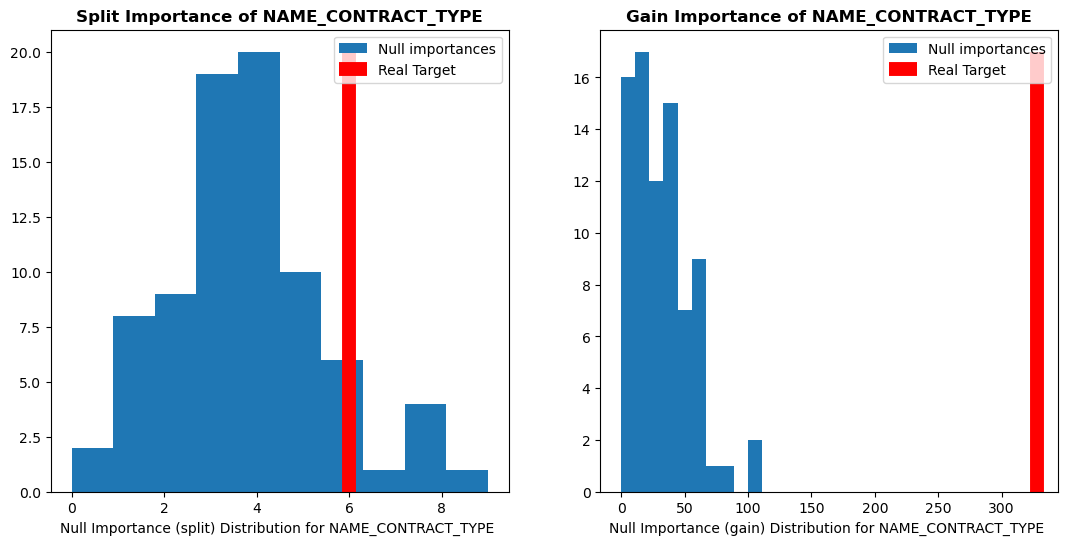

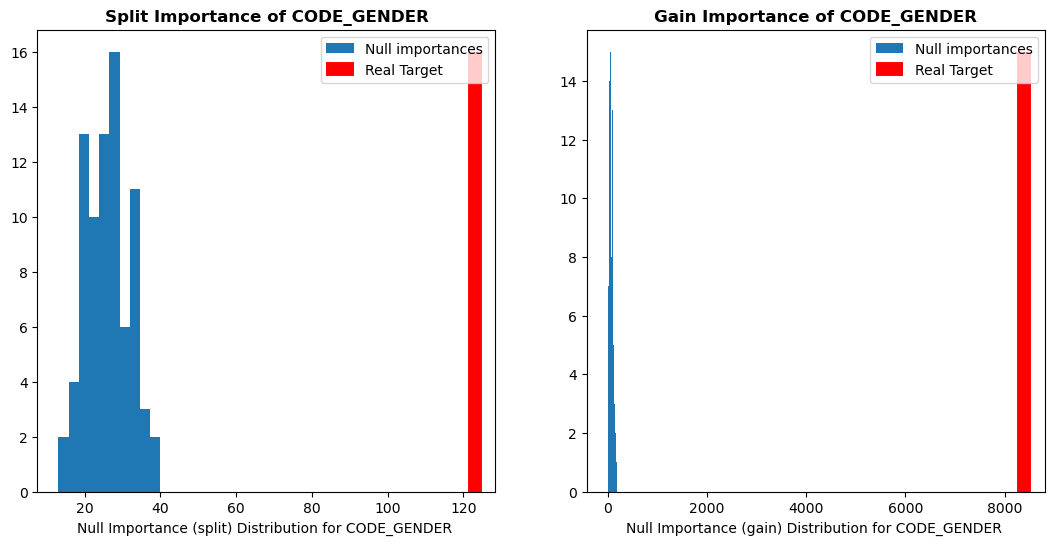

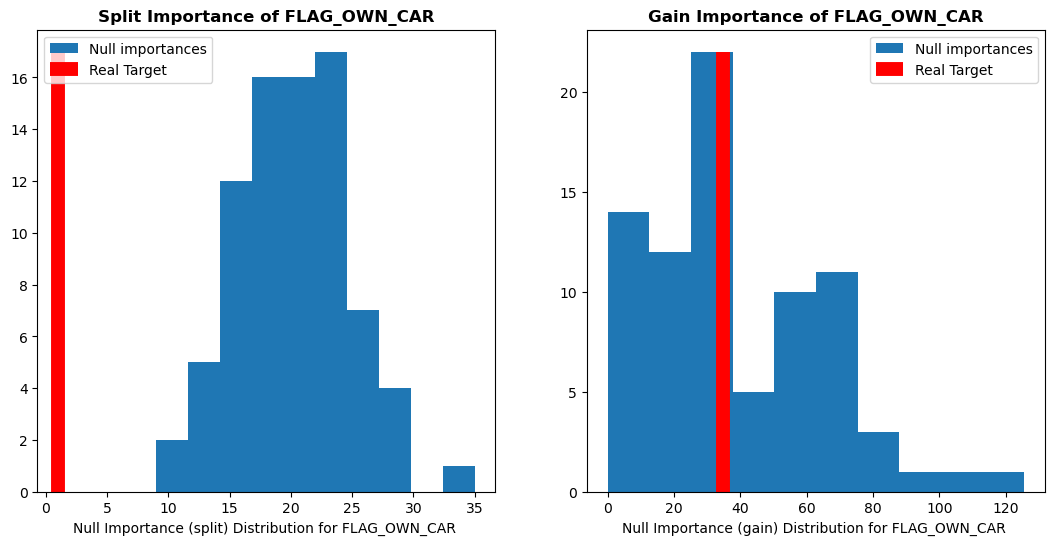

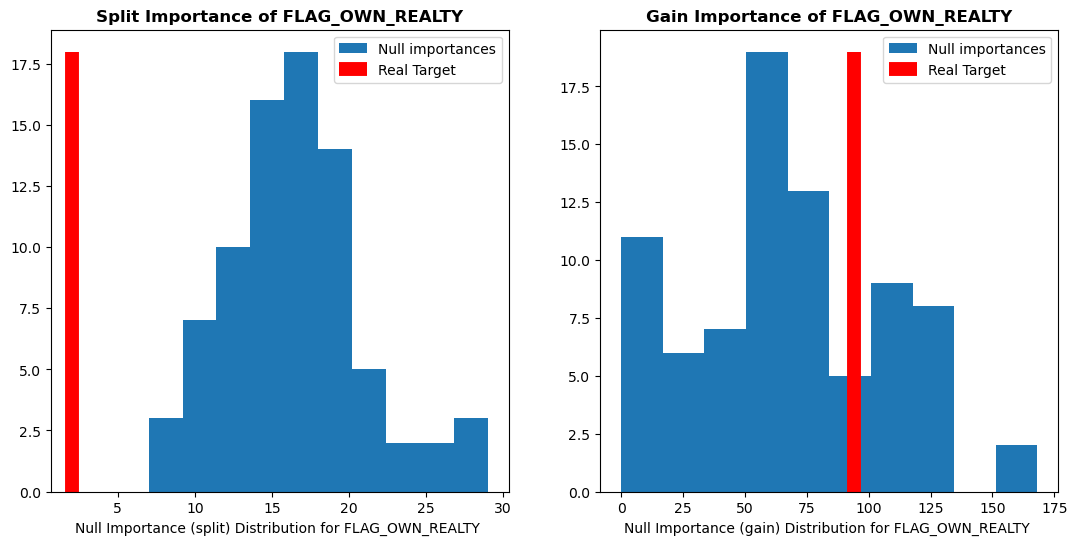

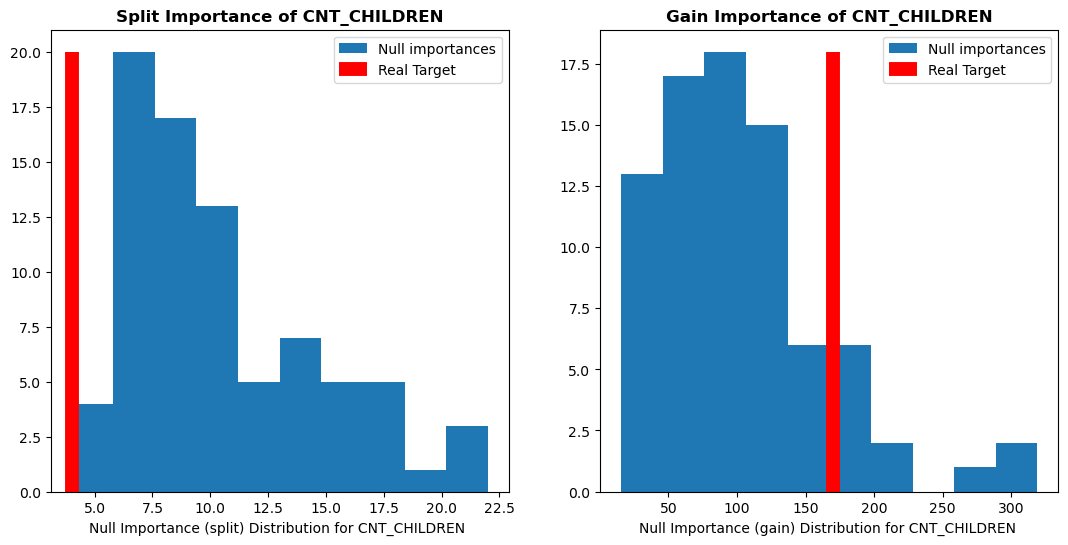

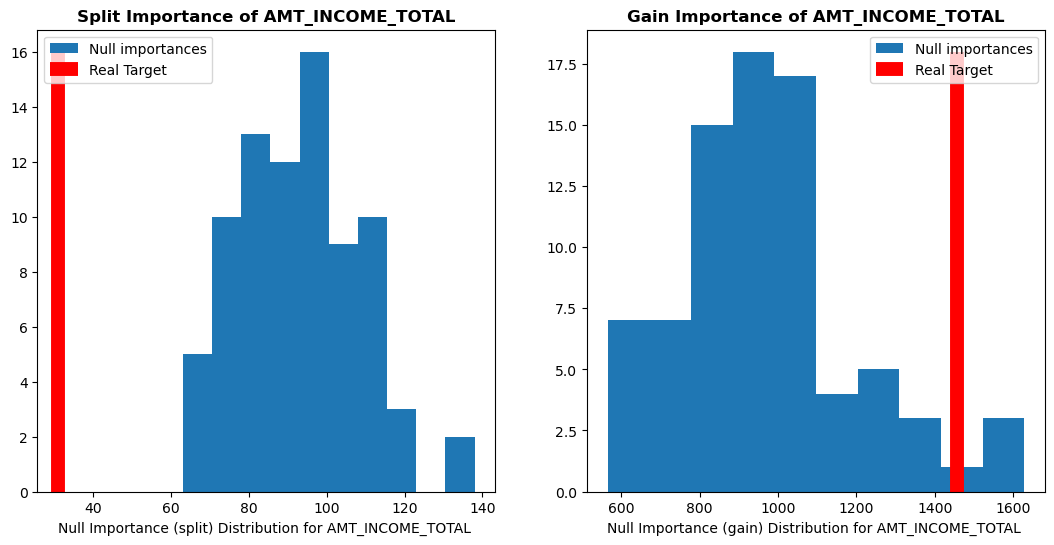

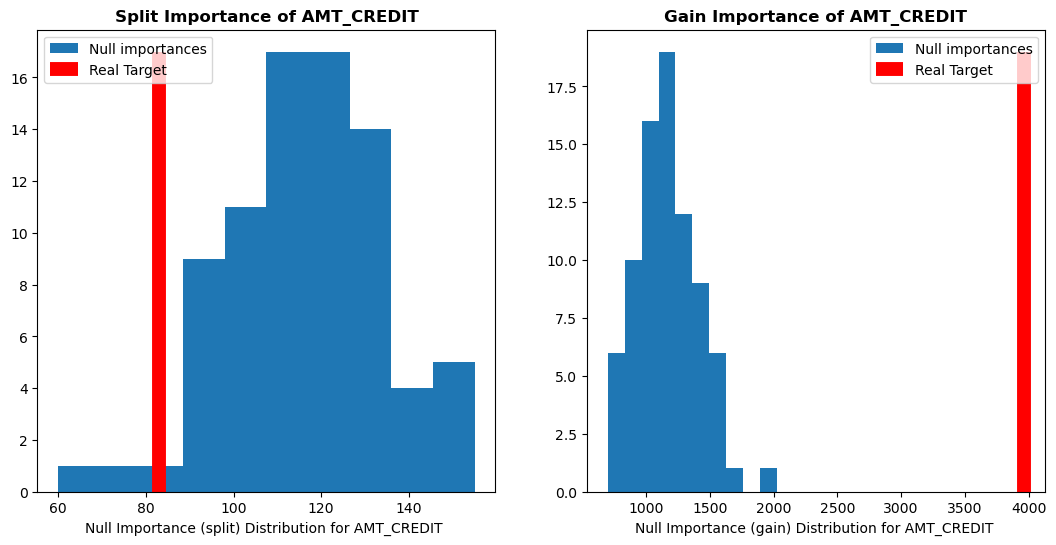

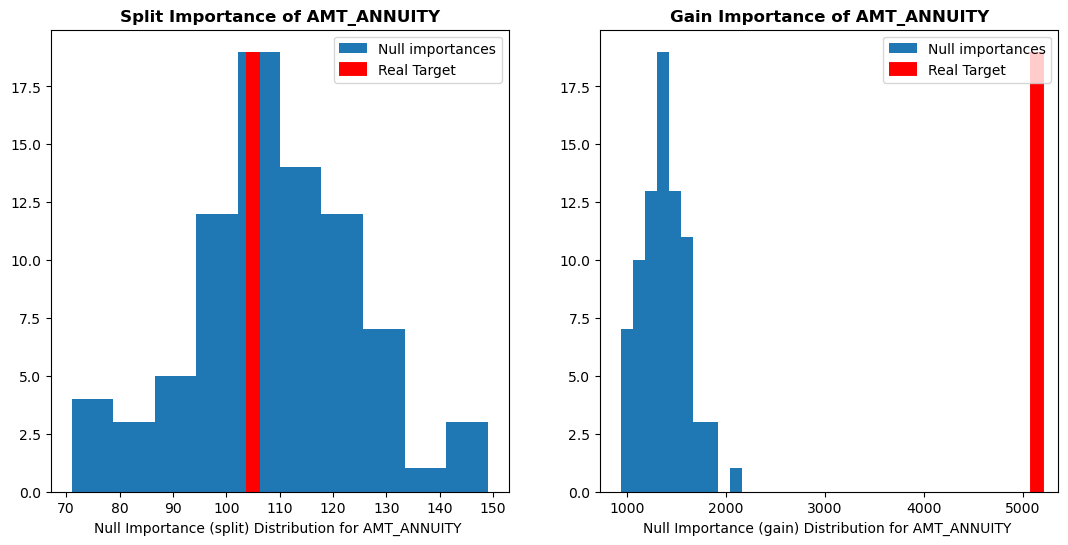

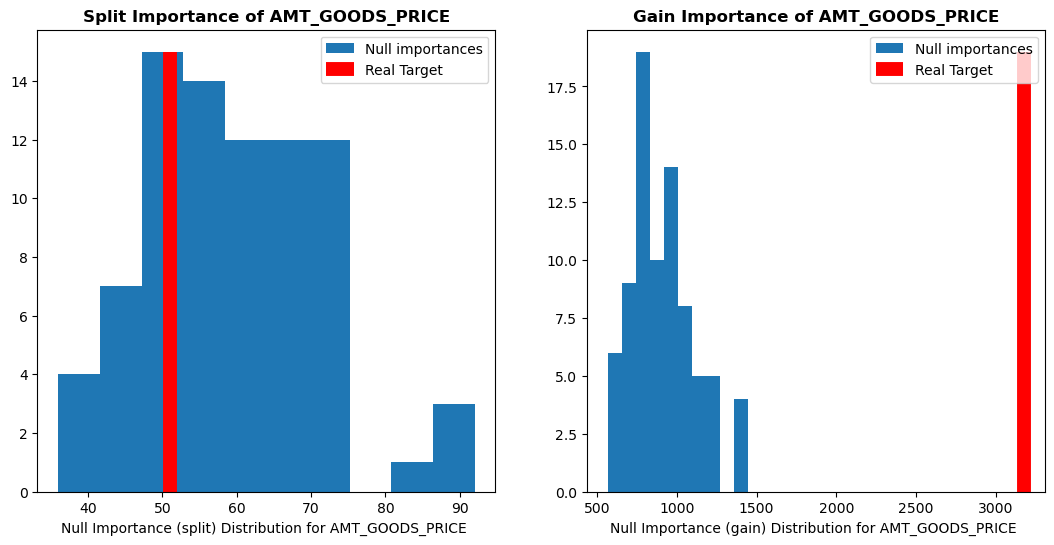

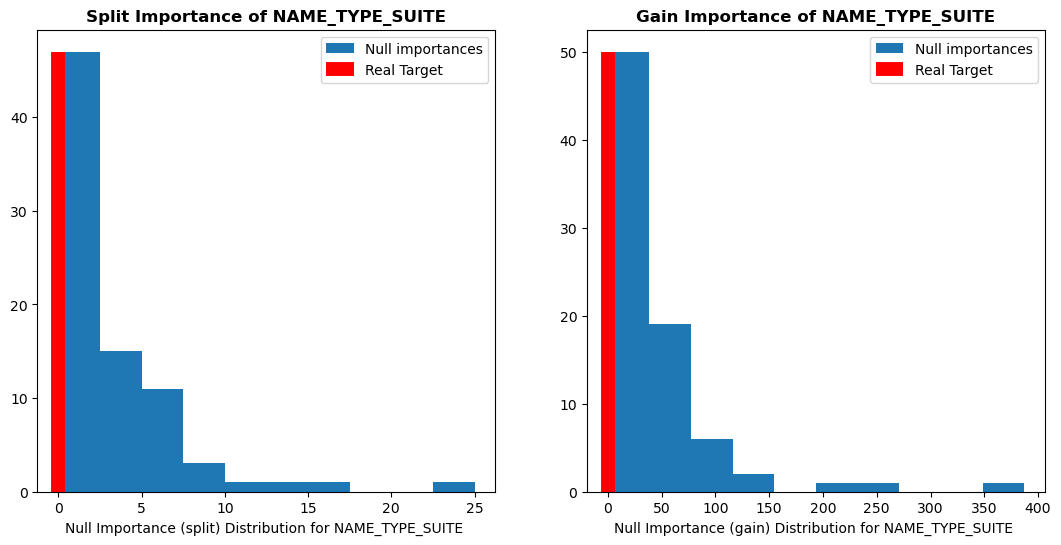

In [38]:
for feature in null_imp_df.feature[:10]:
    display_distributions(
        actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=feature
    )

### Best features

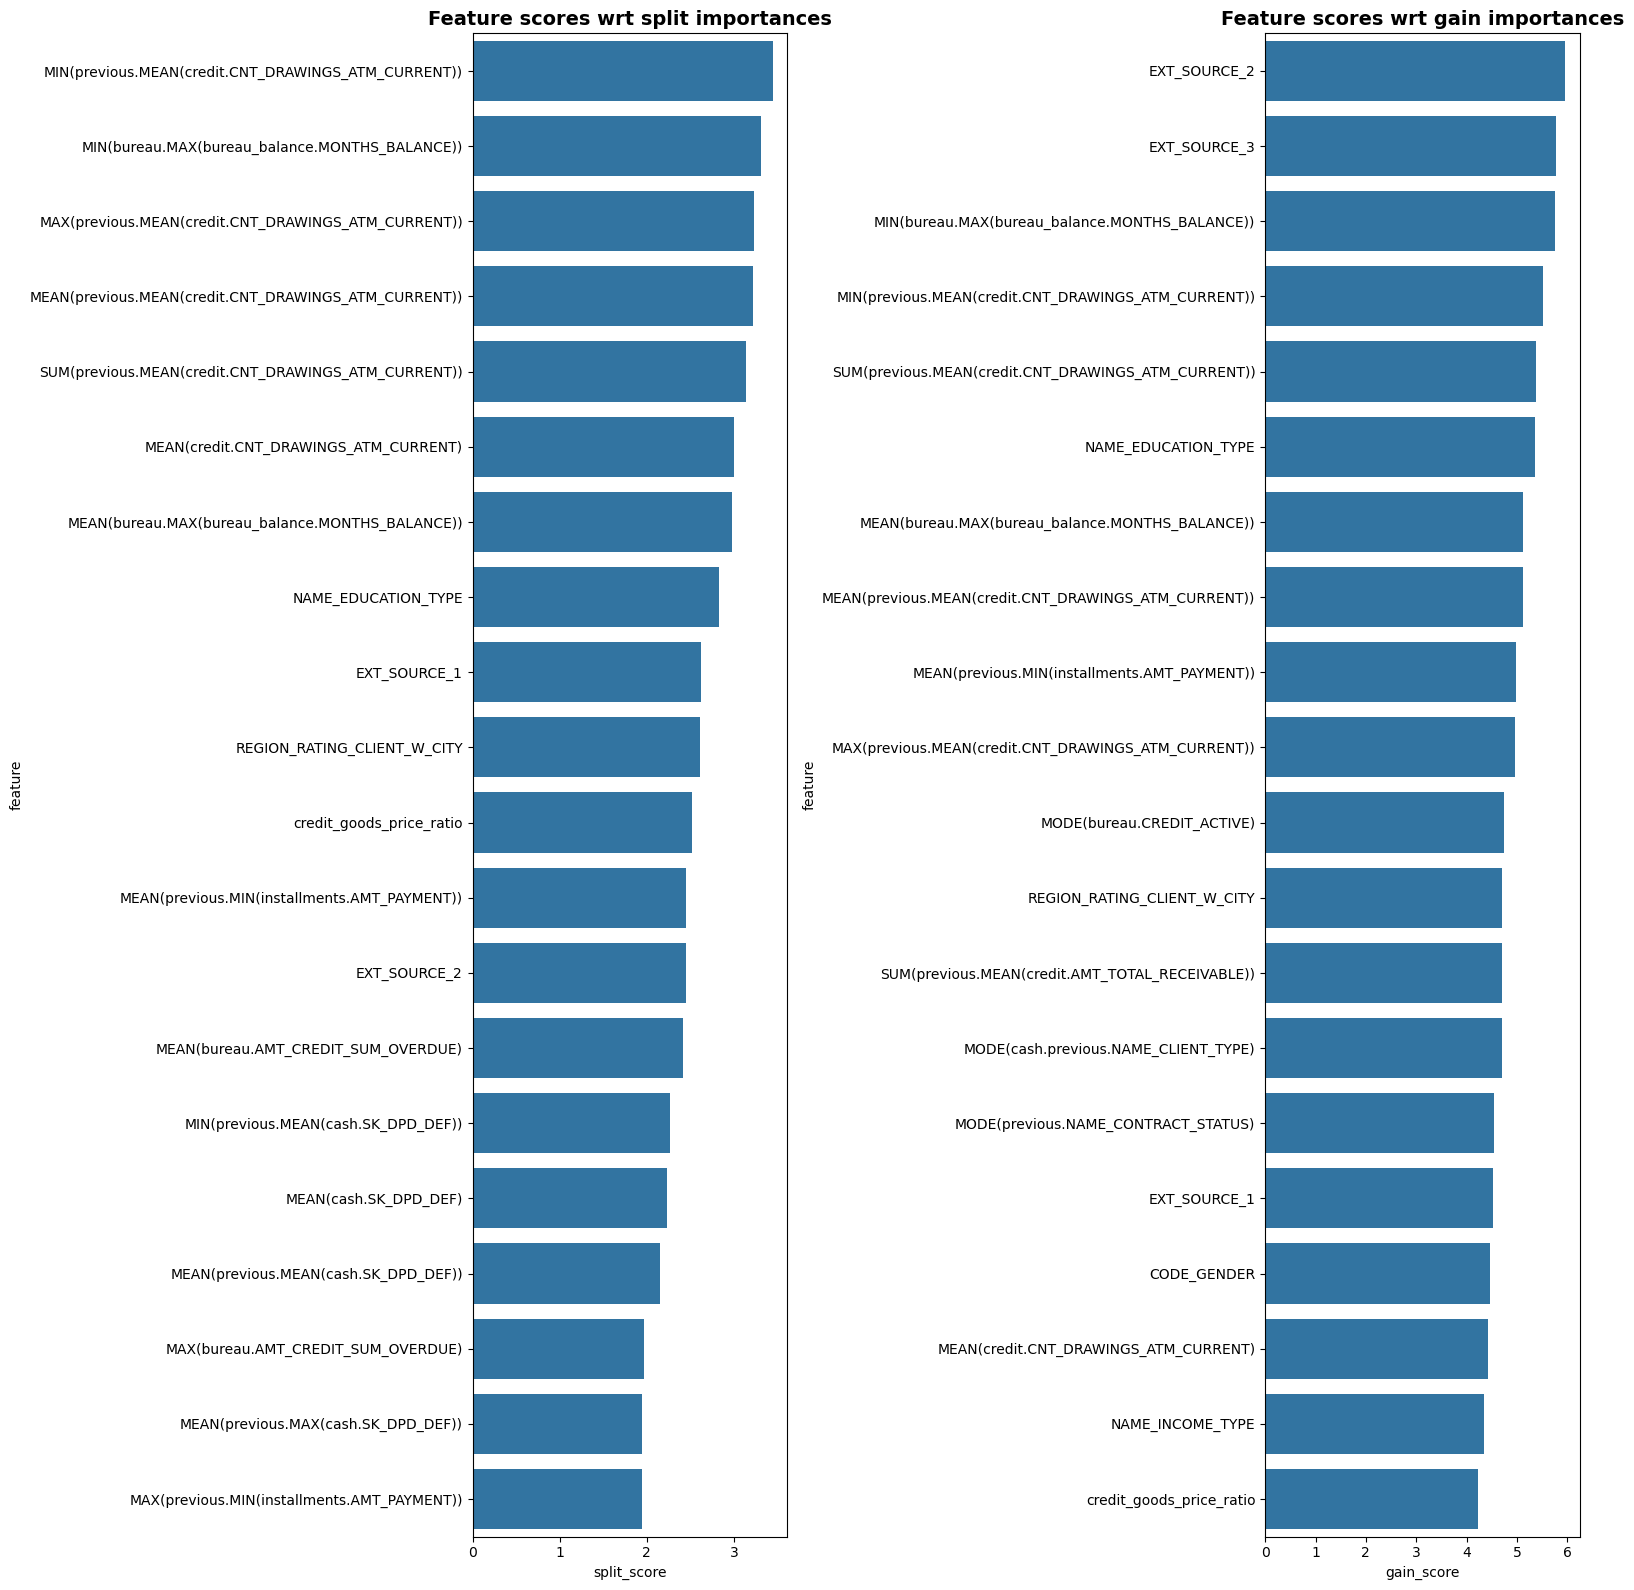

In [39]:
feature_scores = []
for _f in actual_imp_df["feature"].unique():
    f_null_imps_gain = null_imp_df.loc[
        null_imp_df["feature"] == _f, "importance_gain"
    ].values
    f_act_imps_gain = actual_imp_df.loc[
        actual_imp_df["feature"] == _f, "importance_gain"
    ].mean()
    if f_null_imps_gain.size > 0:
        gain_score = np.log(
            1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75))
        )  # Avoid divide by zero
    else:
        gain_score = -1

    f_null_imps_split = null_imp_df.loc[
        null_imp_df["feature"] == _f, "importance_split"
    ].values
    f_act_imps_split = actual_imp_df.loc[
        actual_imp_df["feature"] == _f, "importance_split"
    ].mean()
    if f_null_imps_split.size > 0:
        split_score = np.log(
            1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75))
        )  # Avoid divide by zero
    else:
        split_score = -1

    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(
    feature_scores, columns=["feature", "split_score", "gain_score"]
)

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(
    x="split_score",
    y="feature",
    data=scores_df.sort_values("split_score", ascending=False).iloc[0:20],
    ax=ax,
)
ax.set_title("Feature scores wrt split importances", fontweight="bold", fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(
    x="gain_score",
    y="feature",
    data=scores_df.sort_values("gain_score", ascending=False).iloc[0:20],
    ax=ax,
)
ax.set_title("Feature scores wrt gain importances", fontweight="bold", fontsize=14)
plt.tight_layout();

### Worst features

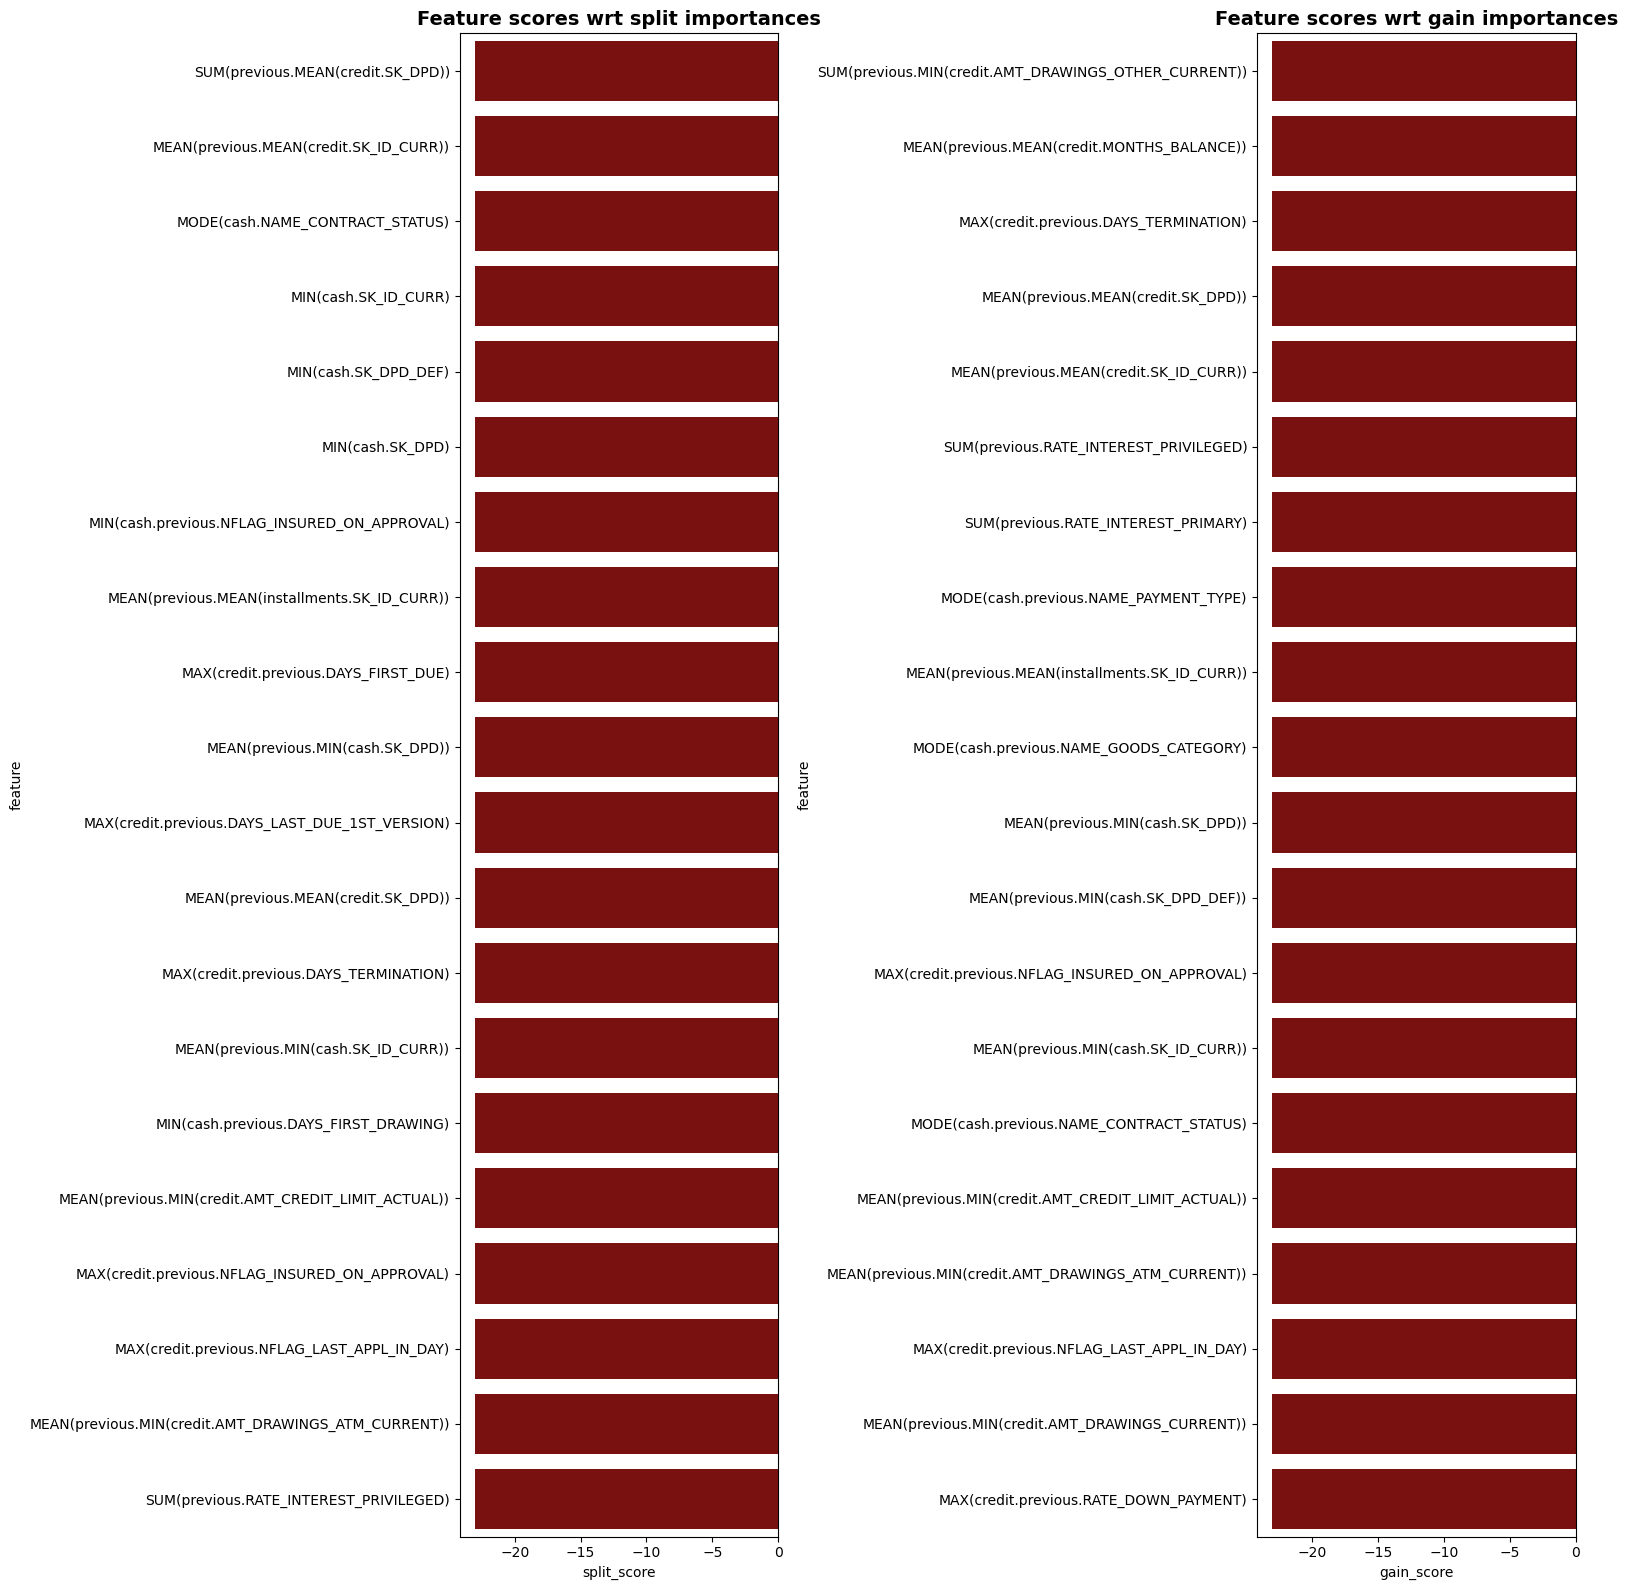

In [40]:
plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(
    x="split_score",
    y="feature",
    data=scores_df.sort_values("split_score", ascending=True).iloc[0:20],
    ax=ax,
    color="darkred",
)
ax.set_title("Feature scores wrt split importances", fontweight="bold", fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(
    x="gain_score",
    y="feature",
    data=scores_df.sort_values("gain_score", ascending=True).iloc[0:20],
    ax=ax,
    color="darkred",
)
ax.set_title("Feature scores wrt gain importances", fontweight="bold", fontsize=14)
plt.tight_layout();

In [41]:
scores_df.to_csv("data/scores_df.csv", index=False)

### Removing useless features

In [42]:
split_score_threshold = -1
gain_score_threshold = 0

# Filter features based on thresholds
useful_features = scores_df[
    (scores_df["split_score"] > split_score_threshold)
    & (scores_df["gain_score"] > gain_score_threshold)
]

# Optional: Remove features with extremely negative scores as a secondary filter
useful_features = useful_features[
    (useful_features["split_score"] > -5) & (useful_features["gain_score"] > -5)
]

len(useful_features)

# remove keep only useful features from feature matrix
feature_matrix_spec = feature_matrix_spec[
    ["set", "TARGET"] + useful_features.feature.to_list()
]

601

# Modelling

#### Data preparation

In [43]:
from sklearn.model_selection import train_test_split

dummied_feature_matrix = pd.get_dummies(feature_matrix_spec)
len(dummied_feature_matrix.columns)

718

In [44]:
features = dummied_feature_matrix[dummied_feature_matrix["set_train"] == 1]
# features = features.sample(n = 50000, random_state = 42)

# Only numeric features
features = features.select_dtypes("number")

# Extract the labels
labels = np.array(features["TARGET"].astype(np.int32)).reshape((-1,))
# features = features.drop(columns = ['TARGET'])

# filter features to only include top features
features = features[dummied_feature_matrix.columns.to_list()]

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=42
)

# drop set_train and set_test columns
train_features = train_features.drop(columns=["set_train", "set_test"])
test_features = test_features.drop(columns=["set_train", "set_test"])

print("Train shape: ", train_features.shape)
print("Test shape: ", test_features.shape)

Train shape:  (230633, 716)
Test shape:  (76878, 716)


In [45]:
train_features.head()

TARGET  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
259386       0    539100.0      27652.5         450000.0   
63267        0    157500.0       7875.0         157500.0   
16579        0    156384.0      16155.0         135000.0   
155405       0    443088.0      24034.5         382500.0   
53130        0     99000.0       5683.5          99000.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
259386                    0.010147      -19802          -6322   
63267                     0.011703      -15032           -127   
16579                     0.010556      -19673          -3969   
155405                    0.028663      -15839          -4227   
53130                     0.031329      -18660           -173   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  \
259386            -5503.0            -3336          NaN               1   
63267             -7331.0            -4563          NaN               1   
16579             -6836.0            -3189          NaN               1   
155405            -8333.0            -4238          NaN               1   
53130             -1951.0            -1674          NaN               1   

        FLAG_WORK_PHONE  FLAG_PHONE  REGION_RATING_CLIENT  \
259386                1           0                     2   
63267                 1           0                     2   
16579                 0           0                     3   
155405                1           1                     2   
53130                 1           1                     2   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
259386                            2                       15   
63267                             2                       13   
16579                             3                       10   
155405                            2                       20   
53130                             2                        9   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
259386                       0                       0   
63267                        1                       1   
16579                        0                       1   
155405                       0                       0   
53130                        0                       0   

        LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
259386                        0      0.572197      0.575546      0.165407   
63267                         0           NaN      0.325363      0.411849   
16579                         1      0.550870      0.437946      0.598926   
155405                        0      0.569085      0.717100      0.720944   
53130                         0           NaN      0.262258           NaN   

        APARTMENTS_AVG  FLOORSMAX_AVG  LIVINGAREA_AVG  \
259386             NaN            NaN             NaN   
63267           0.0722         0.1667          0.0669   
16579              NaN            NaN             NaN   
155405          0.0165         0.0417          0.0000   
53130              NaN            NaN             NaN   

        YEARS_BEGINEXPLUATATION_MODE  LIVINGAREA_MODE  \
259386                           NaN              NaN   
63267                         0.9782           0.0697   
16579                            NaN              NaN   
155405                        0.9811           0.0000   
53130                            NaN              NaN   

        YEARS_BEGINEXPLUATATION_MEDI  LIVINGAREA_MEDI  TOTALAREA_MODE  \
259386                           NaN              NaN             NaN   
63267                         0.9781           0.0681          0.0566   
16579                            NaN              NaN             NaN   
155405                        0.9811           0.0000          0.0121   
53130                            NaN              NaN             NaN   

        DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
259386                       0.0                      

In [46]:
# Separate features and target for the training data
X_train = train_features.drop(columns=["TARGET"])
y_train = train_features["TARGET"]

# Separate features and target for the testing data
X_test = test_features.drop(columns=["TARGET"])
y_test = test_features["TARGET"]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_test = clean_feature_names(X_test)

# Replace infinite values with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Final Train shape: ", X_train.shape)
print("Final Test shape: ", X_test.shape)

Final Train shape:  (230633, 715)
Final Test shape:  (76878, 715)


In [59]:
# sample x_train
X_train_sample = X_train.sample(n=5, random_state=42)
# save to csv
X_train_sample.to_csv("data/X_train_sample.csv", index=False)

In [60]:
X_train_sample.head()

AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
288456    101880.0       7542.0          90000.0                    0.008575   
159763    490536.0      18621.0         405000.0                    0.018801   
60050     282690.0      15462.0         202500.0                    0.020713   
153757    640080.0      31261.5         450000.0                    0.018801   
73137     360000.0      26325.0         360000.0                    0.031329   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
288456      -13352          -5073            -4022.0            -4319   
159763      -15496          -3111             -990.0            -5029   
60050       -13377          -3193            -2200.0            -2474   
153757      -11437           -725            -2576.0            -3883   
73137        -9762           -620             -343.0            -1949   

        OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  \
288456          NaN               1                1           0   
159763          NaN               1                0           1   
60050          13.0               1                0           0   
153757          NaN               1                1           0   
73137           NaN               1                1           1   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
288456                     2                            2   
159763                     2                            2   
60050                      3                            3   
153757                     2                            2   
73137                      2                            2   

        HOUR_APPR_PROCESS_START  REG_CITY_NOT_LIVE_CITY  \
288456                       11                       0   
159763                        6                       0   
60050                         8                       0   
153757                       12                       0   
73137                        13                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
288456                       0                        0           NaN   
159763                       0                        0           NaN   
60050                        0                        0           NaN   
153757                       1                        1           NaN   
73137                        0                        0           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  FLOORSMAX_AVG  \
288456      0.316320      0.676993          0.0188         0.0583   
159763      0.508201      0.598926          0.5804         0.6667   
60050       0.323791      0.504681             NaN            NaN   
153757      0.328611           NaN             NaN            NaN   
73137       0.239789      0.103449          0.1536         0.1667   

        LIVINGAREA_AVG  YEARS_BEGINEXPLUATATION_MODE  LIVINGAREA_MODE  \
288456          0.0174                        0.9791           0.0102   
159763          0.2339                        0.9985           0.2437   
60050              NaN                           NaN              NaN   
153757             NaN                           NaN              NaN   
73137           0.1386                        0.9871           0.1444   

        YEARS_BEGINEXPLUATATION_MEDI  LIVINGAREA_MEDI  TOTALAREA_MODE  \
288456                        0.9816           0.0145          0.0204   
159763                        0.9985           0.2381          0.2967   
60050                            NaN              NaN             NaN   
153757                           NaN              NaN             NaN   
73137                         0.9871           0.1411          0.1099   

        DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
288456                       0.0                       0.0   
159763                       0.0                       0.0   
60050                        0.0       

## Baseline Models

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import pandas as pd
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier


def evaluate_model(model, model_params, X_train, y_train, X_test, y_test):
    # Adjust model with provided parameters
    model.set_params(**model_params)

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Train the model
    model.fit(X_train_imputed, y_train)

    # Predictions
    y_pred = model.predict(X_test_imputed)
    y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert the classification report into a DataFrame
    metrics_df = pd.DataFrame(report).transpose()

    # Add accuracy and AUC to the DataFrame
    metrics_df.loc["Accuracy", "precision"] = accuracy
    metrics_df.loc["AUC", "precision"] = auc_score
    metrics_df.loc[["Accuracy", "AUC"], ["recall", "f1-score"]] = (
        np.nan
    )  # Set non-applicable columns as NaN
    # Add the model name in the df
    metrics_df["model"] = model.__class__.__name__

    return metrics_df

In [48]:
# import time
# start = time.time()
# xgb_params = {'tree_method': 'gpu_hist'}
# xgb_metrics_df = evaluate_model(XGBClassifier(random_state=50), xgb_params, X_train, y_train, X_test, y_test)
# end = time.time()
# print("[XGB] Time taken in seconds: ", end - start)

# # RandomForestClassifier using 6 cores
# start = time.time()
# rf_params = {'n_jobs': 6}
# rf_metrics_df = evaluate_model(RandomForestClassifier(random_state=50), rf_params, X_train, y_train, X_test, y_test)
# end = time.time()
# print("[RF] Time taken in seconds: ", end - start)

# # LightGBM
# start = time.time()
# lgb_params = {'objective': 'binary', 'metric': 'auc', 'seed': 50, 'verbose': -1}
# lgb_metrics_df = evaluate_model(lgb.LGBMClassifier(), lgb_params, X_train, y_train, X_test, y_test)
# end = time.time()
# print("[LGBM] Time taken in seconds: ", end - start)

# # CART (Decision Tree)
# start = time.time()
# cart_metrics_df = evaluate_model(DecisionTreeClassifier(random_state=50), {}, X_train, y_train, X_test, y_test)
# end = time.time()
# print("[CART] Time taken in seconds: ", end - start)

# # Extra Trees
# start = time.time()
# et_metrics_df = evaluate_model(ExtraTreesClassifier(random_state=50), {}, X_train, y_train, X_test, y_test)
# end = time.time()
# print("[ExtraTrees] Time taken in seconds: ", end - start)

# # CatBoost
# start = time.time()
# catboost_params = {
#     'task_type': 'GPU',
#     'devices': '0',  # Specifies the GPU ID to use. For multiple GPUs, use '0:1:2' for GPUs 0, 1, and 2, for example.
#     'random_seed': 50,
#     'silent': True
# }

# # Evaluate CatBoost model
# catboost_metrics_df = evaluate_model(CatBoostClassifier(), catboost_params, X_train, y_train, X_test, y_test)
# end = time.time()
# print("[CB] Time taken in seconds: ", end - start)

# #adaboost
# start = time.time()
# ada_metrics_df = evaluate_model(AdaBoostClassifier(random_state=50),{}, X_train, y_train, X_test, y_test)
# end = time.time()
# print("[ADA] Time taken in seconds: ", end - start)

# rf_metrics_df
# lgb_metrics_df
# cart_metrics_df
# et_metrics_df
# catboost_metrics_df
# xgb_metrics_df
# ada_metrics_df

#### Results

<img src="images/final_results.png" alt="Alternative text" />

#### XGB fine-tuning


Iteration completed in 62.57 seconds.
Best score so far: 0.7795
Best parameters so far:
colsample_bytree: 0.8230311876559941
gamma: 3.6386287158866253
learning_rate: 0.18222690692751073
max_depth: 4
min_child_weight: 2
n_estimators: 271
reg_alpha: 0.0005684034097210144
reg_lambda: 0.04983347481602246
subsample: 0.8956694966554759

Iteration completed in 69.75 seconds.
Best score so far: 0.7818
Best parameters so far:
colsample_bytree: 0.9512165066659852
gamma: 4.416576386904311
learning_rate: 0.07614494765518016
max_depth: 6
min_child_weight: 3
n_estimators: 253
reg_alpha: 4.915216946847741e-05
reg_lambda: 0.0005860531278003445
subsample: 0.9453593652818756

Iteration completed in 63.84 seconds.
Best score so far: 0.7822
Best parameters so far:
colsample_bytree: 0.8334497536903456
gamma: 4.593612608346885
learning_rate: 0.05782311826194557
max_depth: 4
min_child_weight: 1
n_estimators: 273
reg_alpha: 5.987427535052462e-05
reg_lambda: 0.057248308167868925
subsample: 0.9336010634550702


BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'min_child_weight': Integer(low=1, high=3, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=250, high=300, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-05, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-05, high=1.0, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.85, high=1.0, prior='uniform', transform='normalize')})

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Improvement of Best AUC Score over Iterations')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Best AUC Score')

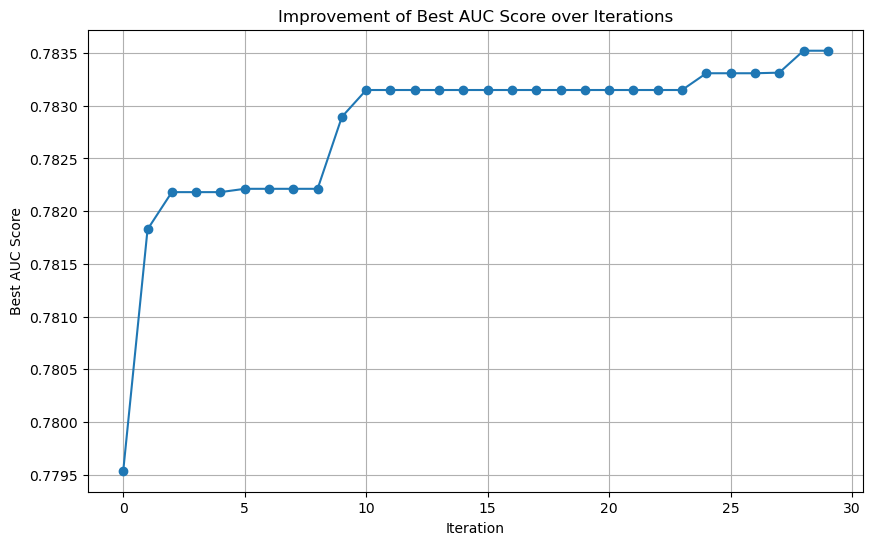

In [55]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeltaYStopper
import time
import matplotlib.pyplot as plt


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        # Lists to store scores and parameter sets
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        # Store the negated best score so far to correct its sign
        best_score_so_far = -res.fun
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        # Extract and store the best parameters so far
        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Initialize the callback
iteration_callback = IterationTrackingCallback()

# Define your XGBClassifier and BayesSearchCV as before
model = XGBClassifier(tree_method="gpu_hist", random_state=42)

search_spaces = {
    "n_estimators": Integer(250, 300),  # Focused around previously identified optimal
    "max_depth": Integer(3, 6),  # Refined based on previous results
    "learning_rate": Real(0.05, 0.2, "log-uniform"),  # Expanded to explore a bit more
    "subsample": Real(0.85, 1.0),  # Adjusted to explore a wider range of subsampling
    "colsample_bytree": Real(0.7, 1.0),  # Corrected to valid range
    "min_child_weight": Integer(1, 3),  # Narrowed focus based on sensitivity
    "gamma": Real(0, 5),  # Optional, to explore if beneficial
    "reg_alpha": Real(1e-5, 1.0, "log-uniform"),  # L1 regularization
    "reg_lambda": Real(1e-5, 1.0, "log-uniform"),  # L2 regularization
}


# Define your XGBClassifier and BayesSearchCV as before
model = XGBClassifier(tree_method="gpu_hist", random_state=42)
opt = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=30,  # Reduced iterations for speed
    scoring="roc_auc",
    cv=5,
    n_jobs=1,  # Keep as 1 for GPU usage
    return_train_score=True,
    refit=True,
    random_state=42,
)
# Fit BayesSearchCV with the callback
opt.fit(X_train, y_train, callback=[iteration_callback])


# Plotting the improvement of scores
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

#### LGBM Fine-tuning

In [49]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Initialize LGBM model with default boosting type 'gbdt'
lgbm_model = lgb.LGBMClassifier(
    objective="binary", boosting_type="gbdt", random_state=42
)

# Define the hyperparameter search space more precisely
search_spaces = {
    "learning_rate": Real(0.01, 0.1, "log-uniform"),
    "num_leaves": Integer(
        30, 60
    ),  # Slightly narrowed based on typical values for binary classification
    "max_depth": Integer(5, 15),
    "min_child_samples": Integer(50, 200),
    "max_bin": Integer(200, 300),
    "subsample": Real(0.7, 0.9, "uniform"),
    "subsample_freq": Integer(0, 7),
    "colsample_bytree": Real(0.7, 1.0, "uniform"),
    "min_child_weight": Integer(1, 9),
    "reg_lambda": Real(0.001, 10, "log-uniform"),
    "reg_alpha": Real(0.001, 1, "log-uniform"),
    "scale_pos_weight": Real(1, 9, "uniform"),  # Adjusted for imbalance
    "n_estimators": Integer(100, 1000),
}

# Scoring function
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Use Stratified K-Fold to handle imbalance
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV setup
opt = BayesSearchCV(
    estimator=lgbm_model,
    search_spaces=search_spaces,
    scoring=scorer,
    cv=cv_strategy,
    n_iter=50,  # Increased iterations for a more thorough search
    return_train_score=True,
    refit=True,
    random_state=42,
    verbose=3,
)

# Fit the model
opt.fit(X_train, y_train)

# Display the best score and parameters
print(f"Best score: {opt.best_score_}")
print("Best parameters:")
for param_name in sorted(opt.best_params_.keys()):
    print(f"{param_name}: {opt.best_params_[param_name]}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14907, number of negative: 169599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152412
[LightGBM] [Info] Number of data points in the train set: 184506, number of used features: 694
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

KeyboardInterrupt: 

#### Catboost Fine-tune

In [50]:
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import numpy as np

# Define the model with GPU support
model = CatBoostClassifier(task_type="GPU", devices="0", random_seed=42, verbose=0)
search_spaces = {
    "depth": Integer(4, 10),
    "learning_rate": Real(0.01, 0.3, "log-uniform"),
    "l2_leaf_reg": Real(1, 10, "uniform"),
    "border_count": Integer(50, 255),
    "iterations": Integer(100, 500),
    "subsample": Real(0.8, 1.0),
    "bootstrap_type": Categorical(
        ["Bernoulli"]
    ),  # Ensuring compatibility with subsample
}

opt = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    n_jobs=1,  # Set to 1 for GPU compatibility
    return_train_score=True,
    refit=True,
    random_state=42,
)

# Fit BayesSearchCV
opt.fit(X_train, y_train)
print(f"Best score: {opt.best_score_}")
print("Best parameters:")
best_params = {
    param_name: opt.best_params_[param_name]
    for param_name in sorted(opt.best_params_.keys())
}
for param_name in sorted(best_params.keys()):
    print(f"{param_name}: {best_params[param_name]}")

BayesSearchCV(cv=5,
              estimator=<catboost.core.CatBoostClassifier object at 0x7f346a69d2a0>,
              n_iter=20, random_state=42, return_train_score=True,
              scoring='roc_auc',
              search_spaces={'bootstrap_type': Categorical(categories=('Bernoulli',), prior=None),
                             'border_count': Integer(low=50, high=255, prior='uniform', transform='normalize'),
                             'depth': Integer(low=4, high=10, prior='uniform', transform='normalize'),
                             'iterations': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'l2_leaf_reg': Real(low=1, high=10, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.8, high=1.0, prior='uniform', transform='normalize')})

Best score: 0.7834338588303592
Best parameters:
bootstrap_type: Bernoulli
border_count: 209
depth: 6
iterations: 450
l2_leaf_reg: 6.33357707775011
learning_rate: 0.07556590575722869
subsample: 0.9297555019407452


**CATBoost**
- Best score: 0.7836752626606263
- Best parameters:
- bootstrap_type: Bernoulli
- border_count: 209
- depth: 6
- iterations: 450
- l2_leaf_reg: 6.33357707775011
- learning_rate: 0.07556590575722869
- subsample: 0.9297555019407452

**LGBM**
- Best score: 0.7491020391405735
- Best parameters:
- colsample_bytree: 0.63418559771339
- learning_rate: 0.010124665300366143
- max_bin: 400
- max_depth: 10
- min_child_samples: 300
- min_child_weight: 10
- n_estimators: 153
- num_leaves: 75
- reg_alpha: 0.06118648759788722
- reg_lambda: 1.0
- scale_pos_weight: 8.258655936861206
- subsample: 0.7832890327649166
- subsample_freq: 10

**XGB**

- Best score: 0.7840216460002207
- Best parameters:
- colsample_bytree: 1.0
- learning_rate: 0.07328812366173859
- max_depth: 5
- min_child_weight: 1
- n_estimators: 300
- subsample: 0.9

In [ ]:
# Best parameters for CatBoost
best_params_cat = {
    "bootstrap_type": "Bernoulli",
    "border_count": 209,
    "depth": 6,
    "iterations": 450,
    "l2_leaf_reg": 6.33357707775011,
    "learning_rate": 0.07556590575722869,
    "subsample": 0.9297555019407452,
}

# Best parameters for LightGBM
best_params_lgb = {
    "colsample_bytree": 0.63418559771339,
    "learning_rate": 0.010124665300366143,
    "max_bin": 400,
    "max_depth": 10,
    "min_child_samples": 300,
    "min_child_weight": 10,
    "n_estimators": 153,
    "num_leaves": 75,
    "reg_alpha": 0.06118648759788722,
    "reg_lambda": 1.0,
    "scale_pos_weight": 8.258655936861206,
    "subsample": 0.7832890327649166,
    "subsample_freq": 10,
}

# Best parameters for XGBoost
best_params_xgb = {
    "colsample_bytree": 1.0,
    "learning_rate": 0.07328812366173859,
    "max_depth": 5,
    "min_child_weight": 1,
    "n_estimators": 300,
    "subsample": 0.9,
}

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pandas as pd


def evaluate_and_plot(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate AUC ROC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print classification report
    print(classification_report(y_test, y_pred))
    print(f"AUC ROC: {roc_auc}")

    # Plot confusion matrix
    confusion_matrix(model, X_test, y_test)
    plt.title(f"Confusion Matrix for {type(model).__name__}")
    plt.show()


import joblib

# Assuming best_params_cat, best_params_lgb, and best_params_xgb are already defined as shown earlier

# Train and save the CatBoost model
cat_model = CatBoostClassifier(**best_params_cat)
cat_model.fit(X_train, y_train)
joblib.dump(cat_model, "models/cat_model.joblib")

# Train and save the LightGBM model
lgb_model = LGBMClassifier(**best_params_lgb)
lgb_model.fit(X_train, y_train)
joblib.dump(lgb_model, "models/lgb_model.joblib")

# Train and save the XGBoost model
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, "models/xgb_model.joblib")

In [ ]:
# Define a function to evaluate and plot the results

cat_model_loaded = joblib.load("models/cat_model.joblib")
lgb_model_loaded = joblib.load("models/lgb_model.joblib")
xgb_model_loaded = joblib.load("models/xgb_model.joblib")


def evaluate_and_plot_loaded_models(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate AUC ROC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"AUC ROC: {roc_auc}\n")

    # Plot confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_mtx, annot=True, fmt="g", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


# Evaluate and plot results for each loaded model
evaluate_and_plot_loaded_models(cat_model_loaded, X_test, y_test, "CatBoost")
evaluate_and_plot_loaded_models(lgb_model_loaded, X_test, y_test, "LightGBM")
evaluate_and_plot_loaded_models(xgb_model_loaded, X_test, y_test, "XGBoost")

# Feature importance

In [ ]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'cat_model_loaded' is the trained CatBoost model and it's already loaded
# Assuming 'X_train' is the feature set used for training the model

# Get feature importances
feature_importances = cat_model_loaded.get_feature_importance(
    Pool(X_train, label=y_train)
)
feature_names = X_train.columns

# Create a Series with feature importances and names, sort it, and select the top 30
top_features = (
    pd.Series(feature_importances, index=feature_names)
    .sort_values(ascending=False)
    .head(20)
)

# Plot
plt.figure(figsize=(10, 8))
top_features.plot(kind="bar")
plt.title("Top 30 Feature Importances for CatBoost")
plt.ylabel("Importance")
plt.show()

In [ ]:
lgb.plot_importance(lgb_model_loaded, max_num_features=20)
plt.title("Feature importances for LightGBM")
plt.show()

In [ ]:
from xgboost import plot_importance

# Assuming 'xgb_model_loaded' is the trained XGBoost model
plot_importance(xgb_model_loaded, max_num_features=20)
plt.title("Feature importances for XGBoost")
plt.show()

In [ ]:
import shap
import pandas as pd

# Assuming 'cat_model' is your trained CatBoost model and 'X_test', 'y_test' are your test datasets

# Predict the positive class
y_pred = cat_model_loaded.predict(X_test)

# Filter to instances where the true label is 1 and the model predicted 1
correct_positives = (y_pred == 1) & (y_test == 1)
X_test_correct_positives = X_test[correct_positives]

# Initialize a SHAP explainer with the model and the subset of correctly predicted positives
explainer = shap.Explainer(cat_model_loaded)
shap_values = explainer.shap_values(X_test_correct_positives)

# Sum the SHAP values for each feature across all the selected instances
shap_sum = np.abs(shap_values).mean(axis=0)

# Create a Series with feature importances for the correctly predicted positive class
feature_importance_positive_class = pd.Series(
    shap_sum, index=X_test.columns
).sort_values(ascending=False)

# Select the top features (e.g., top 30)
top_features_positive_class = feature_importance_positive_class.head(30)

# Plot
plt.figure(figsize=(10, 8))
top_features_positive_class.plot(kind="bar")
plt.title("Top Feature Importances for Correctly Predicted Positive Class (CatBoost)")
plt.ylabel("Mean(|SHAP value|) (impact on model output)")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.show()